# 필요한 라이브러리

In [1]:
import torch
from datasets import Dataset, load_dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline, TrainingArguments
from peft import LoraConfig, PeftModel
from trl import SFTTrainer
import pandas as pd

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import dotenv

dotenv.load_dotenv()

True

# 데이터 전처리

In [3]:
# 전처리 끝난 final.csv
df = pd.read_csv('raft_dataset.csv')
df.head()

,fileName,disease_category,disease_name_kor,department,intention,Question,gpt_document,documents,is_golden,answer
0,HC-A-03595800,근골격질환,족저 근막염,재활의학과,재활,족저 근막염 재활을 위해 어떤 조치를 취해야 하나요?,족저 근막염 재활은 발 건강을 회복하고 통증을 완화하기 위해 다양한 조치들을 취하는...,['족저 근막염 재활은 발 건강을 회복하고 통증을 완화하기 위해 다양한 조치들을 취...,True,족저 근막염 재활을 위해 취해야 할 조치는 다음과 같습니다:\n\n1. **스트레칭...
1,HC-A-07091454,뇌신경정신질환,알코올성 치매,"신경과, 정신건강의학과, 내과",예방,알코올성 치매를 예방하기 위해 어떤 조치를 취해야 하나요?,알코올성 치매의 예방을 위해 다음과 같은 조치를 취할 수 있습니다. 음주량을 줄이는...,['HIV 감염을 치료하거나 관리하기 위해 현재 사용되는 약물은 주로 치료 가능한 ...,True,알코올성 치매를 예방하기 위해서는 다음과 같은 조치를 취하는 것이 중요합니다.\n\...
2,HC-A-03521566,종양혈액질환,전립선암,비뇨의학과,정의,전립선암의 주요 증상은 무엇인가요?,"전립선암은 남성에게 흔히 발생하는 악성 종양으로, 전립선에 암세포가 생기는 질환입니...",['무지외반증 교정기는 엄지발가락을 효과적으로 교정하여 발가락의 변형을 개선하는 치...,True,전립선암의 주요 증상은 주로 배뇨와 관련된 문제들입니다. 다음은 전립선암에서 흔히 ...
3,HC-A-05746826,뇌신경정신질환,편집성 인격장애,정신건강의학과,치료,편집성 인격장애의 치료 방법은 어떤 것들이 있나요?,편집성 인격장애의 치료에는 다양한 방법이 있습니다. 치료에는 정신 치료와 약물 치료...,['편집성 인격장애의 치료에는 다양한 방법이 있습니다. 치료에는 정신 치료와 약물 ...,True,편집성 인격장애의 치료 방법에는 여러 가지가 있습니다. 주로 정신 치료와 약물 치료...
4,HC-A-02685918,유전질환,다운 증후군,내과,증상,다운증후군의 주요 증상은 무엇인가요?,다운증후군은 유전적인 질환으로서 약 700~800명당 한명의 빈도로 나타나는 희귀한...,['다운증후군은 유전적인 질환으로서 약 700~800명당 한명의 빈도로 나타나는 희...,True,"다운증후군의 주요 증상은 여러 가지가 있으며, 각 개인에 따라 다를 수 있습니다. ..."


In [4]:
df = df.drop(columns=['fileName', 'disease_category', 'disease_name_kor', 'department', 'intention', 'gpt_document', 'is_golden'])
df.head()

,Question,documents,answer
0,족저 근막염 재활을 위해 어떤 조치를 취해야 하나요?,['족저 근막염 재활은 발 건강을 회복하고 통증을 완화하기 위해 다양한 조치들을 취...,족저 근막염 재활을 위해 취해야 할 조치는 다음과 같습니다:\n\n1. **스트레칭...
1,알코올성 치매를 예방하기 위해 어떤 조치를 취해야 하나요?,['HIV 감염을 치료하거나 관리하기 위해 현재 사용되는 약물은 주로 치료 가능한 ...,알코올성 치매를 예방하기 위해서는 다음과 같은 조치를 취하는 것이 중요합니다.\n\...
2,전립선암의 주요 증상은 무엇인가요?,['무지외반증 교정기는 엄지발가락을 효과적으로 교정하여 발가락의 변형을 개선하는 치...,전립선암의 주요 증상은 주로 배뇨와 관련된 문제들입니다. 다음은 전립선암에서 흔히 ...
3,편집성 인격장애의 치료 방법은 어떤 것들이 있나요?,['편집성 인격장애의 치료에는 다양한 방법이 있습니다. 치료에는 정신 치료와 약물 ...,편집성 인격장애의 치료 방법에는 여러 가지가 있습니다. 주로 정신 치료와 약물 치료...
4,다운증후군의 주요 증상은 무엇인가요?,['다운증후군은 유전적인 질환으로서 약 700~800명당 한명의 빈도로 나타나는 희...,"다운증후군의 주요 증상은 여러 가지가 있으며, 각 개인에 따라 다를 수 있습니다. ..."


In [5]:
# 위에서 pandas Dataframe으로부터 만들었던 dataset을 매개변수로 받는다.
def generate_raft_prompt(example):

  prompt_list = []
  for i in range(len(example['Question'])):
    prompt = f"""<Question>:{example['Question'][i]} 
<Documents>:{example['documents'][i]}
"""
    prompt_list.append(f"""<bos><start_of_turn>user
{prompt}<end_of_turn>
<start_of_turn>model
<Answer>:{example['answer'][i]}<end_of_turn><eos>""")
  return prompt_list

test = generate_raft_prompt(df.iloc[0:2])
test

["<bos><start_of_turn>user\n<Question>:족저 근막염 재활을 위해 어떤 조치를 취해야 하나요? \n<Documents>:['족저 근막염 재활은 발 건강을 회복하고 통증을 완화하기 위해 다양한 조치들을 취하는 것이 중요합니다. 1. 치료: 족저 근막염 재활의 첫 번째 단계는 스트레칭과 근력강화 운동입니다. 이를 통해 발 아랫부분 근육을 유연하게 만들고 발의 피로를 완화할 수 있습니다. 2. 지지대 사용: 족저 근막염을 치료할 때는 발의 아치를 지원하는 지지대를 사용해야 합니다. 3. 체중 관리: 충분한 식이조절과 체중 관리는 족저 근막염 재활에 도움이 됩니다. 4. 휴식과 활동 조절: 통증이 심한 경우 적절한 휴식을 취하고 활동을 조절하여 발의 근육을 안정화시키세요. 5. 약물 치료: 족저 근막염을 치료하기 위해 스테로이드 제제, 항염증제, 진통제 등의 약물을 사용할 수 있습니다. 이러한 조치들을 취함으로써 족저 근막염 재활을 통해 발건강을 회복하고 통증을 완화할 수 있습니다.', '외상 후 스트레스 장애 치료를 위해 약물 치료가 선택될 수 있습니다. 약물 치료는 다양한 형태의 선택적 세로토닌 재흡수 억제제(SSRI)와 이차적인 약물을 포함합니다. SSRI는 선택적 세로토닌 재흡수 억제제(SSRI)라고도 불리며, 세로토닌과 노르에피네프린의 분비를 조절하여 불안과 우울의 증상을 완화시킵니다. 외상 후 스트레스 장애 치료를 위해 SSRI와 같은 선택적 세로토닌 재흡수 억제제(SSRI)가 사용될 수 있습니다. 그러나 약물 치료는 개별적인 환자 상황에 따라 다를 수 있으므로 약물 치료의 효과를 평가하기 위해서는 의사와의 상담이 필요합니다.']\n<end_of_turn>\n<start_of_turn>model\n<Answer>:족저 근막염 재활을 위해 취해야 할 조치는 다음과 같습니다:\n\n1. **스트레칭과 근력강화 운동**: 족저 근막염의 첫 단계로 발의 아랫부분 근육을 유연하게 하고 피로를 줄이기 위해 스트레칭과 근력강화 운동을 수행하

In [6]:
# 위에서 pandas Dataframe으로부터 만들었던 dataset을 매개변수로 받는다.
def generate_dsf_prompt(example):

  prompt_list = []
  for i in range(len(example['Question'])):
    prompt_list.append(f"""<bos><start_of_turn>user
<Question>:{example['Question'][i]}<end_of_turn>
<start_of_turn>model
<Answer>:{example['answer'][i]}<end_of_turn><eos>""")
  return prompt_list

test = generate_dsf_prompt(df.iloc[0:2])
test

['<bos><start_of_turn>user\n<Question>:족저 근막염 재활을 위해 어떤 조치를 취해야 하나요?<end_of_turn>\n<start_of_turn>model\n<Answer>:족저 근막염 재활을 위해 취해야 할 조치는 다음과 같습니다:\n\n1. **스트레칭과 근력강화 운동**: 족저 근막염의 첫 단계로 발의 아랫부분 근육을 유연하게 하고 피로를 줄이기 위해 스트레칭과 근력강화 운동을 수행하는 것이 중요합니다. 이러한 운동은 발의 회복을 도와줍니다.\n\n2. **지지대 사용**: 발의 아치를 지원하는 지지대를 사용하는 것이 좋습니다. 지지대는 발의 하중을 고르게 분산시켜 통증을 완화하는 데 도움이 됩니다.\n\n3. **체중 관리**: 적절한 식이조절과 체중 관리는 회복을 지원합니다. 체중이 많이 나가면 족저 근막염 증상이 악화될 수 있기 때문에 가능한 체중을 조절하는 것이 중요합니다.\n\n4. **휴식과 활동 조절**: 통증이 심할 경우 적절한 휴식을 취하고 활동을 조절하여 발의 근육을 안정화시키는 것이 필요합니다. 과도한 활동은 상태를 악화시킬 수 있습니다.\n\n5. **약물 치료**: 경우에 따라 스테로이드 제제, 항염증제, 진통제 등의 약물을 사용하여 통증과 염증을 줄이는 것도 고려할 수 있습니다. 이러한 약물은 의사의 처방에 따라 사용해야 합니다.\n\n이러한 조치들을 통해 족저 근막염의 재활을 돕고 발 건강을 회복할 수 있습니다. 계속해서 증상이 심해지거나 변화가 없다면 전문가와 상담하는 것이 좋습니다.<end_of_turn><eos>',
 '<bos><start_of_turn>user\n<Question>:알코올성 치매를 예방하기 위해 어떤 조치를 취해야 하나요?<end_of_turn>\n<start_of_turn>model\n<Answer>:알코올성 치매를 예방하기 위해서는 다음과 같은 조치를 취하는 것이 중요합니다.\n\n1. **음주량 줄이기**: 가장 중요한 예방 방법 중 하나는 음주량을 줄이는 것입니다. 

In [7]:
# pandas 데이터프레임을 Trainer에서 사용하기 위한 dataset 모양으로 변경
dataset = Dataset.from_pandas(df)
print(dataset)

Dataset({
    features: ['Question', 'documents', 'answer'],
    num_rows: 16489
})


# Q - LoRA 파인튜닝

In [8]:
BASE_MODEL = "google/gemma-2b-it"
OUTPUT_DIR = "./raft"
ADAPTER_MODEL = "./raft/lora_adapter/HC"
FINETUNE_MODEL = "./raft/gemma2b-it-ko-HC"

In [9]:
lora_config = LoraConfig(
    r=6, # 저차원 행렬의 랭크(rank) 정의
    lora_alpha = 8, # LoRA에서 사용되는 스케일링(Scaling) 팩터
    lora_dropout = 0.05, # 드롭아웃으로 과적합 방지
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    # LoRA 적용을 위한 모델 내의 특정 레이어(모듈) 지정
    task_type="CAUSAL_LM", # task_type은 LoRA가 적용되는 작업의 유형을 지정함
    # 여기서는 CAUSAL_LM(Causal Language Modeling)을 나타낸다.
)

bnb_config = BitsAndBytesConfig(
    # 입력값을 4 bit로 변환
    load_in_4bit=True,
    # 모델을 4 bit으로 양자화
    bnb_4bit_quant_type="nf4",
    # 4 bit 계산에 사용될 데이터 유형, 4비트 부동소수점(bfloat16), 4비트 정수(uint8)
    bnb_4bit_compute_dtype=torch.float16
)

In [10]:
model = AutoModelForCausalLM.from_pretrained(BASE_MODEL, quantization_config=bnb_config)
# model = get_peft_model(model, lora_config) (https://www.youtube.com/watch?v=McTuvQCXbRY)
# device_map={"":0} 0 번째 GPU를 지정한다는 뜻
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
# 직접 eos토큰을 넣어주지 않는다면 add_eos_token=True 를 추가할 수 있을 것 같다.
tokenizer.padding_side = 'right'
# tokenizer.pad_token = tokenizer.eos_token

`low_cpu_mem_usage` was None, now set to True since model is quantized.
`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


In [11]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    max_seq_length=1024,
    args=TrainingArguments(
        output_dir=OUTPUT_DIR,
        num_train_epochs=3,
        max_steps=-1, # -1로 해야지 epoch수 만큼 돎
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,

        optim="paged_adamw_8bit",
        warmup_ratio=0.03,
        learning_rate=2e-4,
        fp16=True,
        logging_dir="./logs",  # 로그를 저장할 경로
        logging_steps=100,     # 로그를 기록할 스텝 간격
        push_to_hub=False,
        report_to='tensorboard',  # TensorBoard에 로그 기록
    ),
    peft_config=lora_config,
    formatting_func=generate_raft_prompt,   # 알맞은 포맷(raft/dsf)으로 변환하는 함수
)


/opt/conda/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:283: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
Map: 100%|██████████| 16489/16489 [00:09<00:00, 1825.84 examples/s]
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:396: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  wa

In [12]:
#학습
trainer.train()

Step,Training Loss
100,1.765000
200,1.182900
300,1.058500
400,0.968500
500,0.895800
600,0.836800
700,0.800800
800,0.759700
900,0.736500
1000,0.718000


# 파인튜닝 모델 저장

In [16]:
trainer.model.save_pretrained(ADAPTER_MODEL)

base_model = AutoModelForCausalLM.from_pretrained(BASE_MODEL, device_map='auto', torch_dtype=torch.float16)
model = PeftModel.from_pretrained(base_model, ADAPTER_MODEL, device_map='auto', torch_dtype=torch.float16)

model = model.merge_and_unload()
model.save_pretrained(FINETUNE_MODEL)
tokenizer.save_pretrained(FINETUNE_MODEL)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2633: UserWarning: Attempting to save a model with offloaded modules. Ensure that unallocated cpu memory exceeds the `shard_size` (5GB default)
  warnings.warn(


Saving checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Training Loss 값 확인해보기

In [30]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# 이벤트 파일 경로 <- log파일 경로 수정해야함
event_file = 'logs/events.out.tfevents.1726803839.gemma222-76bb7c847b-998pd.5956.0'

# 이벤트 파일 읽기
event_acc = EventAccumulator(event_file)
event_acc.Reload()

# 기록된 스칼라 태그 확인
print(event_acc.Tags()['scalars'])

['train/loss', 'train/grad_norm', 'train/learning_rate', 'train/epoch', 'train/train_runtime', 'train/train_samples_per_second', 'train/train_steps_per_second', 'train/total_flos', 'train/train_loss']


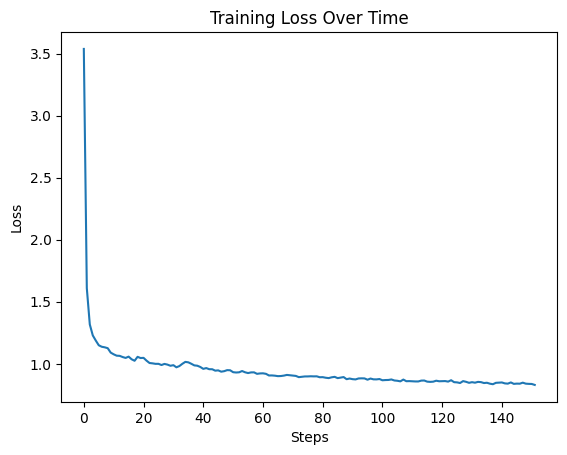

In [32]:
import matplotlib.pyplot as plt

# 손실 값 저장할 리스트
loss_values = []

# 'train/loss' 값 추출
if 'train/loss' in event_acc.Tags()['scalars']:
    loss_events = event_acc.Scalars('train/loss')
    for event in loss_events:
        loss_values.append(event.value)

# 손실 값 그래프 그리기
plt.plot(loss_values)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()